In [1]:
import pandas as pd
import numpy as np 
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import TrOCRProcessor
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import VisionEncoderDecoderModel
import torch
from evaluate import load
import logging
import matplotlib.pyplot as plt 
# Set logging level for transformers to ERROR (or CRITICAL to suppress more)
logging.getLogger("transformers").setLevel(logging.ERROR)


In [2]:
model = VisionEncoderDecoderModel.from_pretrained(f"microsoft/trocr-small-handwritten")
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 61596672


In [3]:
class TrOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # some file names end with jp instead of jpg, the two lines below fix this
        if file_name.endswith('jp'):
          file_name = file_name + 'g'
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    
    


In [4]:
def evaluate(model_path,processor_path, dataset_path):
    
    df = pd.DataFrame(np.load(dataset_path)) 
    df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
    processor = TrOCRProcessor.from_pretrained(processor_path, quiet=True)
    test_dataset = TrOCRDataset(root_dir='',df=df,processor=processor)

    test_dataloader = DataLoader(test_dataset, batch_size=8)
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # device = "mps"
    model = VisionEncoderDecoderModel.from_pretrained(model_path)
    model = model.to(device)
    
    cer = load("cer")
    wer = load("wer") 
    print("Running evaluation...")

    for batch in test_dataloader:
        # predict using generate
        pixel_values = batch["pixel_values"].to(device)
        outputs = model.generate(pixel_values)

        # decode
        pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
        labels = batch["labels"]
        labels[labels == -100] = processor.tokenizer.pad_token_id
        label_str = processor.batch_decode(labels, skip_special_tokens=True)

        
        # add batch to metric
        cer.add_batch(predictions=pred_str, references=label_str)
        wer.add_batch(predictions=pred_str, references=label_str) 
    
    
    return {"cer": cer.compute(), "wer": wer.compute()} 

In [ ]:
max_epochs = 15
test_metrics_list = []
val_metrics_list = []

for i in range(1,max_epochs+1):
    
    test_metrics = evaluate(f"results/pretrained/small_epochs={i}_fulldata", 
                        "microsoft/trocr-small-handwritten", 
                        "data/testset.npy")
    
    val_metrics = evaluate(f"results/pretrained/small_epochs={i}_fulldata",
                          "microsoft/trocr-small-handwritten",
                          "data/valset.npy")
    test_metrics_list.append(test_metrics)
    val_metrics_list.append(val_metrics)
    print(f"Epoch {i} - Val CER: {val_metrics['cer']}, Val WER: {val_metrics['wer']}") 
    print(f"Epoch {i} - Test CER: {test_metrics['cer']}, Test WER: {test_metrics['wer']}")
    
    

Running evaluation...
Running evaluation...
Epoch 1 - Val CER: 0.3571221351900203, Val WER: 0.5517241379310345
Epoch 1 - Test CER: 0.7466266866566716, Test WER: 0.8785425101214575
Running evaluation...
Running evaluation...
Epoch 2 - Val CER: 0.24949231215549753, Val WER: 0.4288240495137047
Epoch 2 - Test CER: 0.4782608695652174, Test WER: 0.6558704453441295
Running evaluation...
Running evaluation...
Epoch 3 - Val CER: 0.19727299100667248, Val WER: 0.38461538461538464
Epoch 3 - Test CER: 0.39730134932533734, Test WER: 0.6032388663967612
Running evaluation...
Running evaluation...
Epoch 4 - Val CER: 0.1560777487670438, Val WER: 0.3147656940760389
Epoch 4 - Test CER: 0.32533733133433285, Test WER: 0.5141700404858299
Running evaluation...
Running evaluation...
Epoch 5 - Val CER: 0.12097476066144473, Val WER: 0.2519893899204244
Epoch 5 - Test CER: 0.20839580209895053, Test WER: 0.3967611336032389
Running evaluation...
Running evaluation...
Epoch 6 - Val CER: 0.14012184508268058, Val WER: 

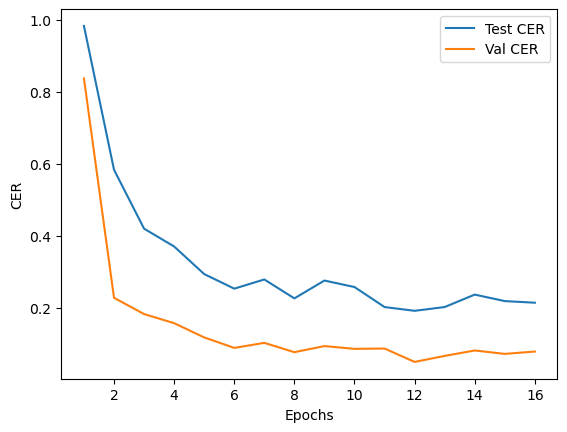

In [9]:
plt.plot(range(1,max_epochs+1), test_cers, label="Test CER")
plt.plot(range(1,max_epochs+1), val_cers, label="Val CER")
# name the x-axis
plt.xlabel("Epochs")
# name the y-axis
plt.ylabel("CER")
plt.legend()